# [Public Policy 275] Spatial Data and Analysis, Fall 2022

# Lab 5: Fields

* University of California, Berkeley
* Instructor: Solomon Hsiang
* GSIs: Simon Greenhill and Hikari Murayama

**About This Lab**
* Due Date: September 27, 2022
* You may talk with other students about the lab, but each student is responsible for doing all exercises in the lab themselves and turning in their own write up. We will be checking code for evidence of copying and pasting.
* When you are done with the lab, please restart the kernel and run all the codes one more time (press the ">>" button), so that the grader will see a clean notebook. Don't forget to save! Please submit this lab to bCourses as `YOURCAL1ID.ipynb`. This will facilitate anonymous grading.
* In addition your `ipynb` file, please also submit a PDF version of it. You can do this by saving and exporting as a PDF. If that's not working, save and export as a HTML, save and export it as an HTML and then print it to a PDF file.
* This lab requires that you download the following files and place them in the same directory as this jupyter notebook:
    * `Lab5_GPW.tif`
    * the shapefile of the country that you mapped in Lab 4
* These labs have been developed over the years by Solomon Hsiang, and past/current GSIs including Ian Bolliger, Tamma Carleton, Shubham Goel, Felipe González, Luna Yue Huang, Jonathan Kadish, Jaecheol Lee, and Jonathan Proctor (in alphabetical order).

## Objectives
By the end of this lab, you will be able to
1. Use `rasterio`
2. Use `Proj`, for reprojecting coordinates

In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import rasterio.transform
import rasterio.mask
import rasterio.warp
import rasterio.windows

# for 3d plotting
from mpl_toolkits.mplot3d import Axes3D
# color
from matplotlib.colors import LinearSegmentedColormap
# managing colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

# for country file
import shapely

In [2]:
%matplotlib inline

### Important Caveat: Matplotlib Interactive Mode

Everyone's jupyter notebook is configured differently. For some reasons, figures rendered in interactive mode (if you ran `%matplotlib notebook`) is sometimes not embedded properly in the notebook, which means that if you send your notebook to someone else, e.g., the grader, they cannot see any of the figures. We want to ask you to, before turning in this notebook, turn off the interactive mode (clear all output and run `%matplotlib inline` instead) so that the graders can see all the graphs. Thank you so much!

The interactive mode is great for view 3D graphs and finding a good angle to display data, etc. so we still highly encourage you to use it when you are working through the problems or in your final project.

## 1. Let's Get Visual

**1.1.**

Start by constructing a field based on a function that you know. To do this, let's first define the space we want to examine by describing the axes. We define the axes by specifying their end points and the number of points in between. We describe the axes in each dimension as follows.


Begin by defining the width of a grid, $\delta$ (for simplicity, we'll just assume resolution is same in the x and y directions):

In [3]:
delta = 1

then using this parameter, we describe the axis in each dimension using a vector for each.

In [4]:
x_axis = np.arange(start=-5, stop=5 + delta, step=delta)
y_axis = np.arange(start=-5, stop=5 + delta, step=delta)

These two vectors describe a space where there are grid points centered at 121 locations (draw a picture for yourself if you don’t know why). It’s easy to define functions over this space using map algebra. To do this, we construct two matrices, one that describes the location of each grid point in the x-dimension, and one that describes the locations of each grid point in the y-dimension. The command meshgrid takes as inputs the two vectors that define the space and outputs these two matrices.

Run

In [5]:
X_grid, Y_grid = np.meshgrid(x_axis, y_axis)

and take a look at the two output matrices below.

In [6]:
X_grid

array([[-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5]])

In [7]:
Y_grid

array([[-5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5],
       [-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4],
       [-3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3],
       [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5]])

Each is a 2-D matrix, not a vector. Each element can be indexed based on our usual notation, e.g. `X_grid[3, 4]` is a number. This number describes the position of that grid cell in the x-dimension (-1). Similarly, the value at `Y_grid[3, 4]` describes the position of that same grid cell in the y-dimension (-2).

Importantly, the indices of the numpy array (here it was [3, 4]) do not correspond to the x and y positions of the grid cell in the space defined by our vectors (here it was [-1, -2]). If we changed the endpoints of our original axes, or their resolution, the matrices output by meshgrid would look very different and so `Y_grid[3, 4]` or `X_grid[3, 4]` would take on different values. To avoid confusion, we usually refer to elements in a matrix using the indices (i, j) and we refer to the locations in space using the coordinates (x, y) or (lon, lat).

**What location in x-y space do the elements in position (i=8, j=9) of X_grid and Y_grid correspond to?**

In [8]:
# TODO: WRITE YOUR CODES HERE
print("The elements in position (i=8, j=9) \
of X_grid and Y_grid correspond to location \
({},{})".format(X_grid[8,9], Y_grid[8,9]))

The elements in position (i=8, j=9) of X_grid and Y_grid correspond to location (4,3)


The two matrices `X_grid` and `Y_grid` are so useful because we can do map algebra on them to generate new functions (fields) that are defined at each location in x and y. For example, start with a simple plane

In [9]:
Q_field = X_grid + 2 * Y_grid

If you examine the matrices `Q_field` with `X_grid` or `Y_grid`, you can see how the values of `Q_field` are computed at each point based on these other two matrices/arrays. Visualize this field by running the code block below:

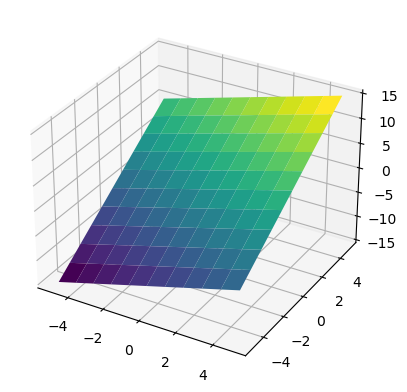

In [10]:
# initialize the matplotlib figure
fig = plt.figure()
# tell matplotlib our axes are three-dimensional
# this is similar to a question in Lab 2
ax = fig.add_subplot(1, 1, 1, projection='3d')
# here we plot the surface
ax.plot_surface(X_grid, Y_grid, Q_field, cmap='viridis')
plt.show()

As we have seen in Lab 2, you can make jupyter interactive by
```
%matplotlib notebook
```
and you can play around with rotating the figure using the cursor. However, if you replace this line with 
```
%matplotlib inline
```
your figures will be static, which is better for reproducibility if you want to save the images to files. You can spin the 3-D figure around in static mode by running the code below. Note that elev angles up/down, and azim rotates clockwise/counterclockwise.
``` 
ax.view_init(elev=30, azim=-125)
```
Now, using some of the codes shown above, plot the surface of Q_field, and remember to label your axes.

**Turn in your correctly labeled plot**.

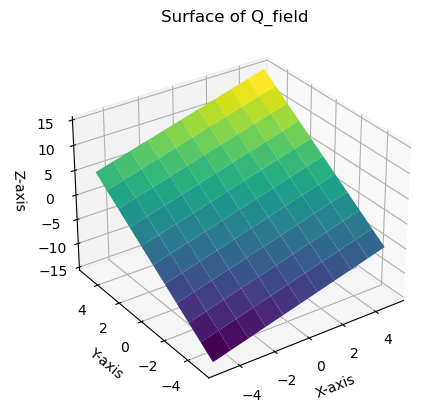

In [11]:
# TODO: PLOT HERE
# initialize the matplotlib figure
fig = plt.figure()
# tell matplotlib our axes are three-dimensional
# this is similar to a question in Lab 2
ax = fig.add_subplot(1, 1, 1, projection='3d')
# here we plot the surface
ax.plot_surface(X_grid, Y_grid, Q_field, cmap='viridis')
# TO DO: WHAT ANGLE TO SHOW (E.G. Elev)
ax.view_init(elev=30, azim=-125)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Surface of Q_field")
plt.show()

**1.2.**

Try making a more interesting field so we can explore matplotlib's visualization functions. Try constructing the field

$$Z = 40 - 0.4X^2 + 2Y - 0.5Y^2$$

with map algebra using the matrices/arrays X_grid and Y_grid.

In [12]:
# TODO: WRITE YOUR CODES HERE
Z_field = 40 - 0.4*(X_grid**2) + 2*Y_grid - 0.5*(Y_grid**2)
Z_field


#also plot

array([[ 7.5, 11.1, 13.9, 15.9, 17.1, 17.5, 17.1, 15.9, 13.9, 11.1,  7.5],
       [14. , 17.6, 20.4, 22.4, 23.6, 24. , 23.6, 22.4, 20.4, 17.6, 14. ],
       [19.5, 23.1, 25.9, 27.9, 29.1, 29.5, 29.1, 27.9, 25.9, 23.1, 19.5],
       [24. , 27.6, 30.4, 32.4, 33.6, 34. , 33.6, 32.4, 30.4, 27.6, 24. ],
       [27.5, 31.1, 33.9, 35.9, 37.1, 37.5, 37.1, 35.9, 33.9, 31.1, 27.5],
       [30. , 33.6, 36.4, 38.4, 39.6, 40. , 39.6, 38.4, 36.4, 33.6, 30. ],
       [31.5, 35.1, 37.9, 39.9, 41.1, 41.5, 41.1, 39.9, 37.9, 35.1, 31.5],
       [32. , 35.6, 38.4, 40.4, 41.6, 42. , 41.6, 40.4, 38.4, 35.6, 32. ],
       [31.5, 35.1, 37.9, 39.9, 41.1, 41.5, 41.1, 39.9, 37.9, 35.1, 31.5],
       [30. , 33.6, 36.4, 38.4, 39.6, 40. , 39.6, 38.4, 36.4, 33.6, 30. ],
       [27.5, 31.1, 33.9, 35.9, 37.1, 37.5, 37.1, 35.9, 33.9, 31.1, 27.5]])

**1.3.** 

Once you have constructed the field, make a heat map that displays values for $Z$ at each location in x-y space using color. To see what color corresponds to which value of $Z$, use the `fig.colorbar()` function and a labeled color spectrum (a "colorbar") will show up on your figure. See below

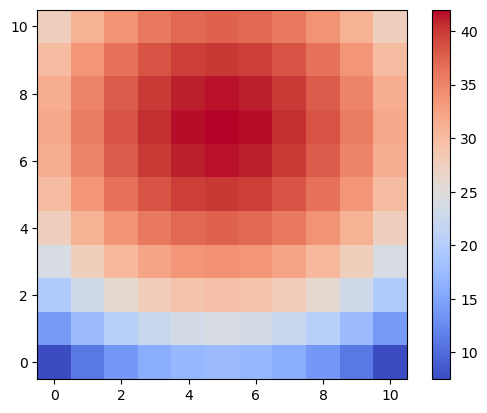

In [13]:
fig, ax = plt.subplots()
im = ax.imshow(Z_field, cmap='coolwarm', origin='lower')
fig.colorbar(im, ax=ax)
plt.show()

Examine your y-axis in the plot. Is it labeled correctly? What's wrong with it? Try the commands

```python 
ax.set_xticklabels(x_axis)
ax.set_yticklabels(y_axis)
```

Report what they do. Does it help you draw your figure correctly?

What would happen if you pass the argument `origin='lower'` to `ax.imshow()`?

**Label your axes correctly, title you plot, and include a colorbar. Turn in a plot where the lower left corner has the x, y coordinates as [-5, -5].**

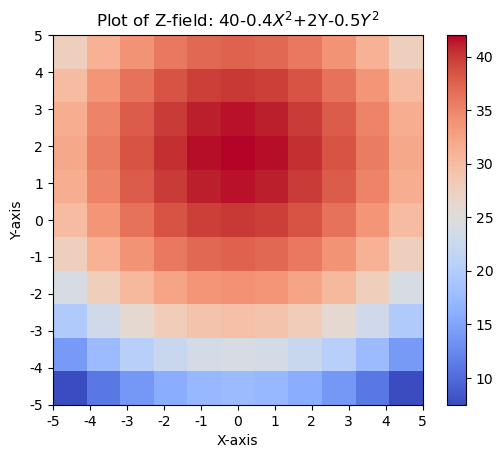

In [14]:
# TODO: WRITE YOUR CODES HERE
fig, ax = plt.subplots()
im = ax.imshow(Z_field, cmap='coolwarm', \
               extent=[-5,5,-5,5], \
               origin='lower')
fig.colorbar(im, ax=ax)
plt.xticks(x_axis)
plt.yticks(y_axis)
ax.set_xticklabels(x_axis)
ax.set_yticklabels(y_axis)
ax.set_title("Plot of Z-field: 40-$0.4X^2$+2Y-$0.5Y^2$")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
plt.show()

# Simply setting the x and y tick labels to x_axis and y_axis wasn't sufficient.
# Running that code set the range from -4 to 1 (although the raw data was accurate).
# To solve that, I overrode the x and y tick labels with plt.x/yticks.
# However, that actually expanded the graph (it was interpreting -5,-5 as 0,0 since those are the indices in Z)
# To solve that, I changed the extent parameter in ax.imshow to -5 to 5 for both x and y.
# I also needed to set the origin to lower to flip the data, and have the origin be the lowest values, 
# rather than the upper left

**1.4.**  

The color spectrum you are using has a maximum and minimum color that correspond with a maximum and minimum value for Z. You can keep the color spectrum and Z the same but “stretch out” or “shrink” the numerical limits of the color spectrum by feeding arguments into the `imshow()` function. If you change your codes in the above cell to `ax.imshow(Z_field, cmap='coolwarm', vmin=0, vmax=100)`, `vmin` will describe the lower bound of the color spectrum and `vmax` the upper bound. These, for example, will make the color axis stretch from 0 to 100.

**Make a three-subplot figure, with each subplot displaying a heat map of Z and with its own colorbar. The first panel should use matplotlib's default color axis. The second should use a color axis that spans 0-100. The third should use a color axis that spans 0-10. Make sure all three plots are labeled.**

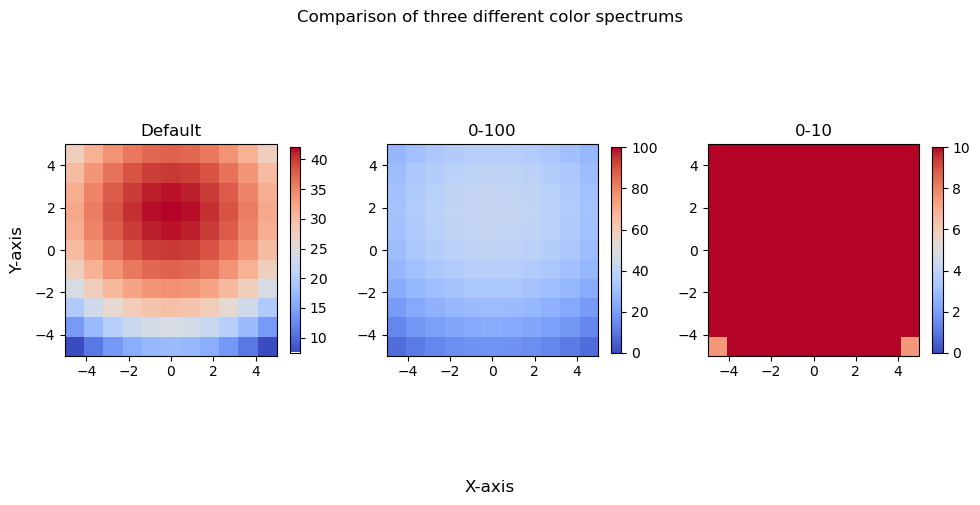

In [15]:
# TODO: WRITE YOUR CODES
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,5))
im = ax1.imshow(Z_field, cmap='coolwarm', \
               extent=[-5,5,-5,5], \
               origin='lower')
fig.colorbar(im, ax=ax1, shrink=0.5)

im2 = ax2.imshow(Z_field, cmap='coolwarm', \
               extent=[-5,5,-5,5], \
               origin='lower', vmin=0, vmax=100)
fig.colorbar(im2, ax=ax2, shrink=.5)

im3 = ax3.imshow(Z_field, cmap='coolwarm', \
               extent=[-5,5,-5,5], \
               origin='lower', vmin=0, vmax=10)
fig.colorbar(im3, ax=ax3, shrink=0.5)

ax1.set_title("Default")
ax2.set_title("0-100")
ax3.set_title("0-10")
fig.supxlabel("X-axis")
fig.supylabel("Y-axis")
fig.suptitle("Comparison of three different color spectrums")
fig.tight_layout()

**1.5.**  

The rainbow color spectrum used to plot out values of $Z$ can be changed without changing the underlying data or the z-axis. The spectrum used to color a field is an object called the colormap. In the function `imshow()` we used above, the argument `cmap='coolwarm'` defines the colormap.

If you run `plt.colormaps()`, a list will appear with all the availabe colormaps (you can also write your own colormap, but it's much easier to use a pre-defined one). You can see what these [look like here](https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html). The color scheme that matplotlib uses by default is known as 'viridis', but you can change to the color scheme 'bone' using either by specifiying `cmap` in the `imshow()` function or by omitting this argument and instead running the command
```python
plt.set_cmap('bone')
```
before `plt.show()`.

**Select or design two colormaps that are not used above and display $Z$ using these colormaps in two separate figures that are labeled, properly oriented, and have colorbars for each figure.**

Note: If you want to, you can also design your own colormap manually (not required for this question). For instance, a red-yellow-white scale would be:
```python
from matplotlib.colors import LinearSegmentedColormap
color_scheme = ['red', 'yellow', 'white']
custom_cmap = LinearSegmentedColormap.from_list('RedYellowWhite', color_scheme)
plt.register_cmap(cmap=custom_cmap)
```
and then run
```python
plt.set_cmap(custom_cmap)
```
or use the `cmap=custom_cmap` argument in the `imshow()` function. If you're brave and care enough about palettes, you can also set a highly customized color scheme and specify the RGB values for each color used in the scheme. Refer to the [matplotlib tutorial here](https://matplotlib.org/3.1.0/gallery/color/custom_cmap.html) for more information.

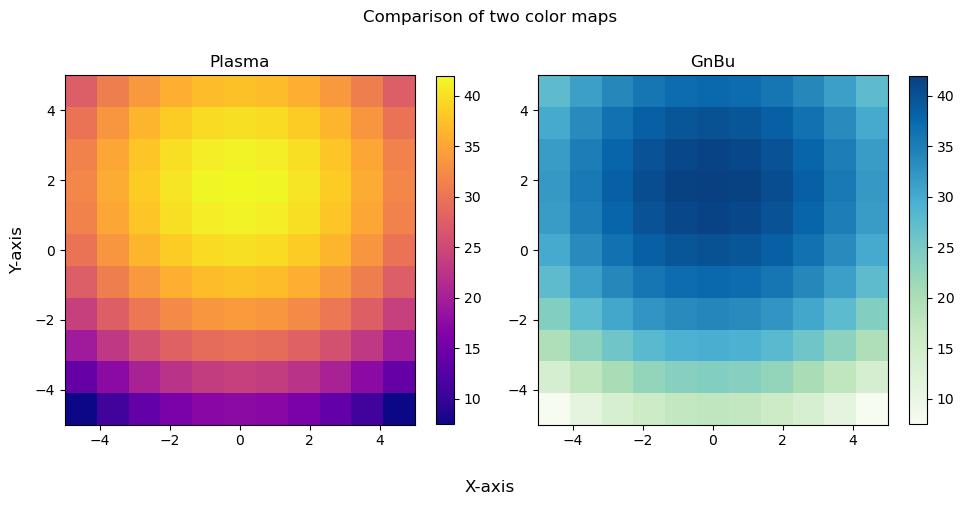

In [16]:
# TODO: WRITE YOUR CODES
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
im = ax1.imshow(Z_field, cmap='plasma', \
               extent=[-5,5,-5,5], \
               origin='lower')
fig.colorbar(im, ax=ax1, shrink=0.85)

im2 = ax2.imshow(Z_field, cmap='GnBu', \
               extent=[-5,5,-5,5], \
               origin='lower')
fig.colorbar(im2, ax=ax2, shrink=0.85)

ax1.set_title("Plasma")
ax2.set_title("GnBu")
fig.supxlabel("X-axis")
fig.supylabel("Y-axis")
fig.suptitle("Comparison of two color maps")
fig.tight_layout()

**1.6.**   

Display the field $Z$ using a contour plot. There are two main contour-plotting commands, so do this on a two subplot figure.

**In the first subplot, use contour(X_grid, Y_grid, Z_field) with whatever colormap you want.**
The syntax is similar to before:
```python
fig, ax = plt.subplots()
ax.contour(X_grid, Y_grid, Z_field, cmap='coolwarm')
plt.show()
```
**In the second panel, generate the identical plot but use the command contourf instead. (The "f" is for "fill"). Turn this in.**

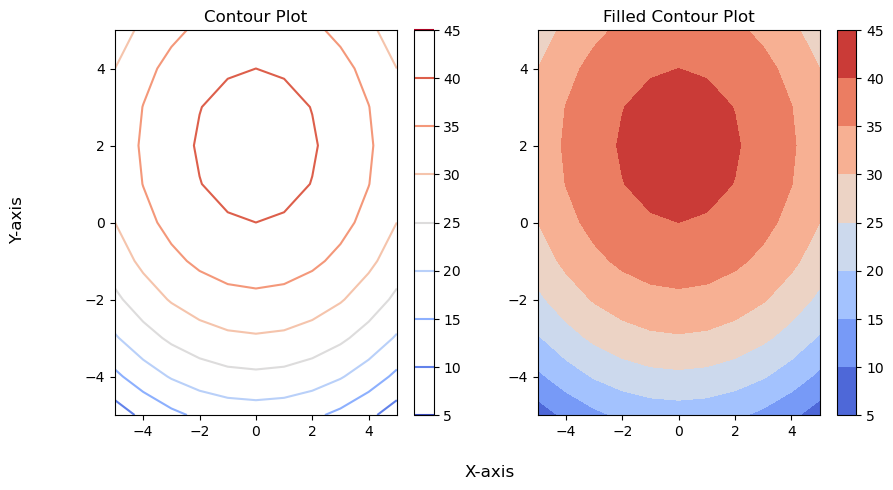

In [17]:
# TODO: PLOT HERE
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
im = ax1.contour(X_grid, Y_grid, Z_field, cmap='coolwarm')
ax1.set_title("Contour Plot")
fig.colorbar(im, ax=ax1)
im2 = ax2.contourf(X_grid, Y_grid, Z_field, cmap='coolwarm')
ax2.set_title("Filled Contour Plot")
fig.colorbar(im2, ax=ax2)

fig.supxlabel("X-axis", verticalalignment='top') # For some reason, top makes this look regular, and others don't!
fig.supylabel("Y-axis", horizontalalignment="left") # Left looks better to me than default

plt.show()

**1.7.**   

Display the field $Z$ using 3-D plots. You can use `plot_surface()` that we used before for the plane. Try `plot_wireframe()` as well. The syntax here is:

```python
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_wireframe(X_grid, Y_grid, Z_field)
plt.show()
```

There are a lot of choices in [the mplot3d tutorials](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html). For all of these plots, you can grab the figure and change the viewing angle if you are in interactive mode, otherwise use `ax.view_init()` for viewpoint rotation.

**Pick your three favorite displays and show them in a three subplot figure using any colormap you like. Make sure each is labeled clearly.**

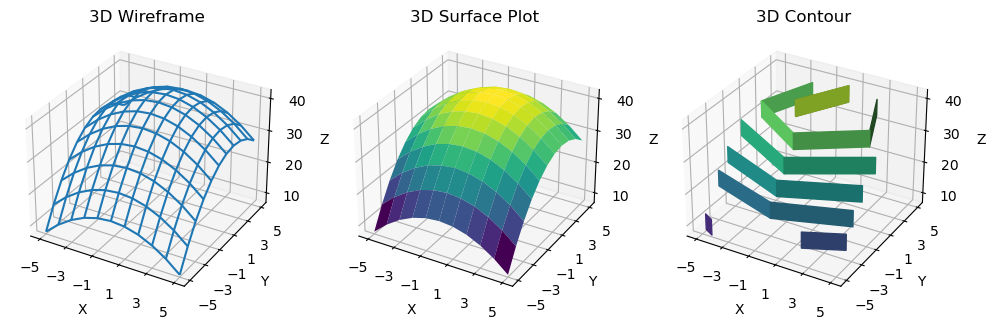

In [49]:
# TODO: WRITE YOUR CODES HERE
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(12,6))

# Plotting 3D Wireframe Plot
ax = fig.add_subplot(1, 3, 1, projection='3d')
im = ax.plot_wireframe(X_grid, Y_grid, Z_field)
ax.set_title("3D Wireframe")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.xticks([-5, -3, -1, 1, 3, 5])
plt.yticks([-5, -3, -1, 1, 3, 5])

# Plotting 3D Surface Plot
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
im2 = ax2.plot_surface(X_grid, Y_grid, Z_field, cmap='viridis')
ax2.set_title("3D Surface Plot")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")

plt.xticks([-5, -3, -1, 1, 3, 5])
plt.yticks([-5, -3, -1, 1, 3, 5])

# Plotting 3D Contour Plot
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
im3 = ax3.contour(X_grid, Y_grid, Z_field, extend3d=True)
ax3.set_title("3D Contour")
ax3.set_xlabel("X")
ax3.set_ylabel("Y")
ax3.set_zlabel("Z")

plt.xticks([-5, -3, -1, 1, 3, 5])
plt.yticks([-5, -3, -1, 1, 3, 5])

plt.show()

## 2. Int rp lati g pol ti n

In [19]:
obs_x = np.array([-4, -1, 0, 3])
obs_p = np.array([17.2, 3.4, 2, -1])

**2.1.**

Your job is to estimate air pollution levels at various locations along a one-dimensional street. Houses on the street are spaced evenly at a grid-spacing of $\delta = 1$. The houses are numbered from $-5$ to $+5$ (the actual house numbers have been removed from the data set for privacy). You have only four pollution measurements

$$\tilde{P} = \{(−4, 17.2), (−1, 3.4), (0, 2), (3, −1)\}$$

where the first element in each observation is the house number and the second element is the
pollution level.

**Plot these four pollution observations as a bar plot (Hint: your vertical axis is pollution; you can use `plt.bar()`). Make sure that your figure shows the full length of the street, even though there are not observations at all locations. Be sure to label the axes of your plot.**

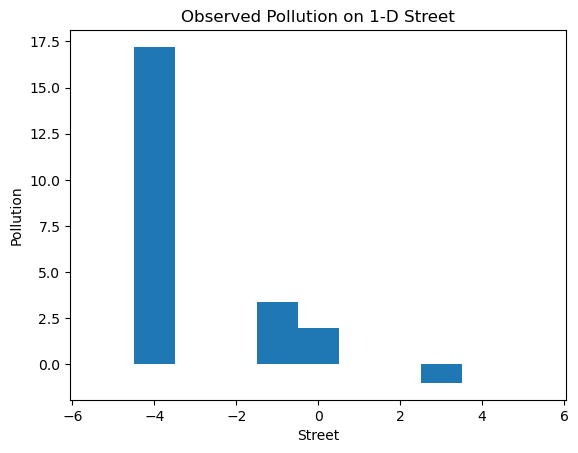

In [20]:
# TODO: WRITE YOUR CODES HERE
delta=1
x_values = np.arange(-5,6,1)
pollution = np.zeros([1,11])

for i in range(len(x_values)):
    for location, pol in zip(obs_x, obs_p):
        if x_values[i]==location:
            pollution[0][i]=pol

plt.bar(x=x_values, height=pollution[0], width=delta)
plt.xlabel("Street")
plt.ylabel("Pollution")
plt.title("Observed Pollution on 1-D Street")
plt.show()

**2.2.**

Estimate the pollution level at each of the 11 house locations using nearest neighbor interpolation, i.e. each house should be assigned the same pollution level as that house's nearest neighbor that has an actual pollution observation. **Plot your results, using a bar plot for the actual observations and some other marker (e.g. '+') for interpolated values.**

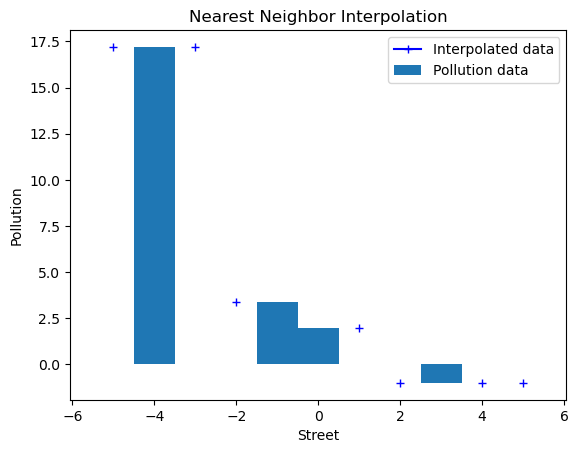

In [21]:
# TODO: WRITE YOUR CODES HERE

def plot_nearest_neighbor(values: np.array, coordinates: np.array, mark="+", plot=True):
    """
    values: An array of values (in this case, pollution)
    coordinates: location of each point in 1-D space
    
    Takes in array of values and coordinates, and then plots the nearest neighbor for 0 values
    """
    nearest_neighbor = np.zeros([1,11])
    for i in range(len(values[0])):
        left_neighbor = np.nan
        right_neighbor = np.nan
        if values[0][i]==0: 
            # For each value, if it's zero, look for it's closest neighbor
            for j in range(len(values[0])):
                # Modular math to ensure we can look in both directions
                if np.isnan(left_neighbor) and values[0][(i-j)%len(values[0])]!=0:
                    left_neighbor = values[0][(i-j)%len(values[0])]
                    # if we assign a nearest neighbor, break out of the loop
                    break
                if (np.isnan(right_neighbor)) and (values[0][(i+j)%len(values[0])]!=0):
                    right_neighbor = values[0][(i+j)%len(values[0])]
                    break
                
        # plot nearest neighbor
        if np.isnan(right_neighbor)==False:
            nearest_neighbor[0][i]=right_neighbor
            if plot:
                plt.plot(i-5, right_neighbor, marker=mark, color='blue')
        elif np.isnan(left_neighbor)==False:
            nearest_neighbor[0][i]=left_neighbor
            if plot:
                plt.plot(i-5, left_neighbor, marker=mark, color='blue')
    return nearest_neighbor

delta=1
x_values = np.arange(-5,6,1)
pollution = np.zeros([1,11])

for i in range(len(x_values)):
    for location, pol in zip(obs_x, obs_p):
        if x_values[i]==location:
            pollution[0][i]=pol

coordinates = np.arange(-5,6,1)

plot_nearest_neighbor(pollution, coordinates)

            
plt.bar(x=x_values, height=pollution[0], width=delta, label="Pollution data")
plt.plot([],[],marker="+", color='blue', label='Interpolated data')
plt.xlabel("Street")
plt.ylabel("Pollution")
plt.title("Nearest Neighbor Interpolation")
plt.legend()
plt.show()

**2.3.**

Estimate the pollution level at each of the 11 house locations using inverse-distance weighting interpolation. Use weights equal to $\frac{1}{{distance}^2}$. **Plot your results, using a bar plot for the actual observations and some other marker for interpolated values.**

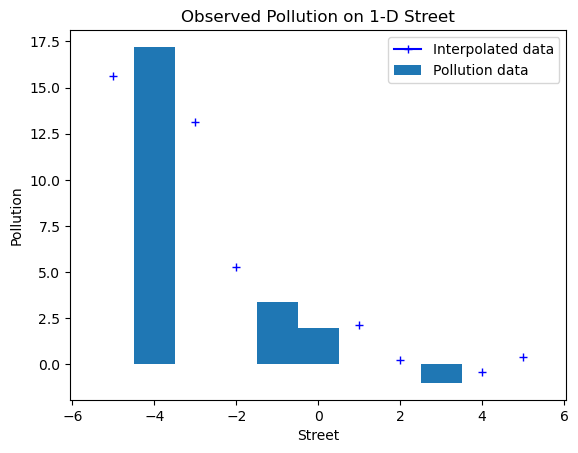

In [22]:
# TODO: WRITE YOUR CODES HERE

def plot_inverse_distance(values: np.array, coordinates: np.array, mark="+", plot=True):
    """
    values: An array of values (in this case, pollution)
    coordinates: location of each point in 1-D space
    
    Takes in array of values and coordinates, and then plots the inverse distance for 0 values
    """
    values = values[0]
    inverse_distance = np.zeros([1,11])
    for i in range(len(values)):
        if values[i]==0:
            distance = 0
            sum_distance = 0
            sum_weight = 0
            for j in range(len(values)):
                if values[j]!=0:
                    distance = abs(j-i)
                    if distance !=0:
                        distance = distance ** (-2)
                    weight = values[j]
                    weight = weight * distance
                    sum_distance = sum_distance + distance
                    sum_weight = sum_weight + weight
            inverse_dist = sum_weight/sum_distance
            inverse_distance[0][i] = inverse_dist
            if plot:
                plt.plot(i-5,inverse_dist,marker=mark, color='blue')
    return inverse_distance

delta=1
x_values = np.arange(-5,6,1)
pollution = np.zeros([1,11])

for i in range(len(x_values)):
    for location, pol in zip(obs_x, obs_p):
        if x_values[i]==location:
            pollution[0][i]=pol

coordinates = np.arange(-5,6,1)
plot_inverse_distance(pollution, coordinates)

plt.bar(x=x_values, height=pollution[0], width=delta, label="Pollution data")
plt.plot([],[],marker='+', color='blue', label='Interpolated data')
plt.xlabel("Street")
plt.ylabel("Pollution")
plt.title("Observed Pollution on 1-D Street")
plt.legend()
plt.show()

**2.4.**

The true pollution field (which you were not able to observe) is described by 
$$pollution = 2 -x+\frac{3}{10}x^2-\frac{1}{10}x^3$$
where $x$ is the house number. 

**Create a figure displaying the entire street that overlays (1) the true pollution field, (2) the pollution observations, (3) estimates of the pollution field based on nearest neighbor interpolation, and (4) estimates of the pollution field based on inverse distance weighting.**

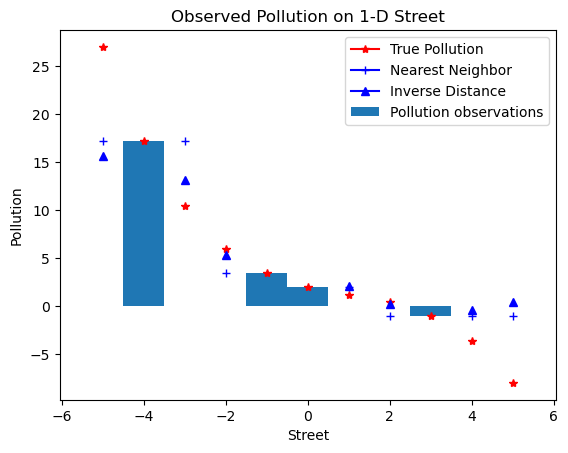

In [23]:
# TODO: WRITE YOUR CODES HERE
house_number = np.arange(-5,6,1)
true_pollution = [2 - i + (3/10*i**2) - ((i**3)/10) for i in house_number]
true_pollution

delta=1
x_values = np.arange(-5,6,1)
pollution = np.zeros([1,11])
coordinates = np.arange(-5,6,1)

# Plotting observed pollution
for i in range(len(x_values)):
    for location, pol in zip(obs_x, obs_p):
        if x_values[i]==location:
            pollution[0][i]=pol

plt.bar(x=x_values, height=pollution[0], width=delta, label="Pollution observations")

# Plotting true pollution
for i in range(len(true_pollution)):
    plt.plot(i-5, true_pollution[i], marker="*", color='red')
plt.plot([],[], marker="*", color='red', label='True Pollution')
 

# Plotting nearest neighbor pollution
plot_nearest_neighbor(pollution, coordinates, "+")
plt.plot([],[], marker="+", color='blue', label="Nearest Neighbor")


# Plotting inverse distance
plot_inverse_distance(pollution, coordinates, "^")
plt.plot([],[], marker="^", color='blue', label="Inverse Distance")

plt.xlabel("Street")
plt.ylabel("Pollution")
plt.title("Observed Pollution on 1-D Street")
plt.legend()
plt.show()

**2.5.**

Evaluate the error caused by these two methods. 

**Make a plot of the street displaying the error at each location for each of the two interpolation techniques (error is the difference between the estimated pollution level at a location and the true pollution level at that location). Did the nearest neighbor technique ever outperform (or perform as well as) the inverse distance weighting technique?**

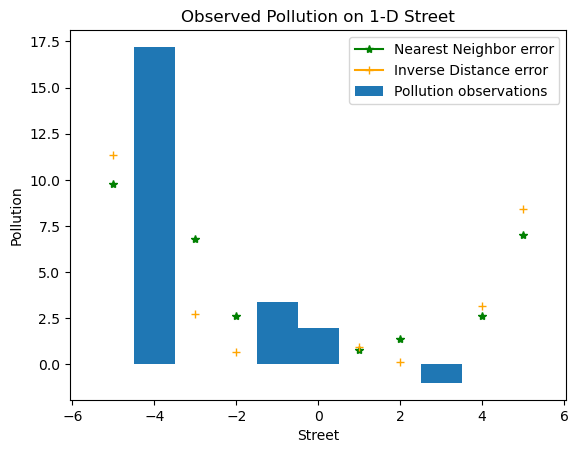

In [24]:
# TODO: WRITE YOUR CODES HERE
delta=1
x_values = np.arange(-5,6,1)
pollution = np.zeros([1,11])

for i in range(len(x_values)):
    for location, pol in zip(obs_x, obs_p):
        if x_values[i]==location:
            pollution[0][i]=pol

# Calculate nearest neighbor error
nearest_neighbor = plot_nearest_neighbor(pollution, coordinates, "+", plot=False)
error = true_pollution - nearest_neighbor
for i in range(len(nearest_neighbor[0])):
    if nearest_neighbor[0][i]!=0:
        plt.plot(i-5, abs(error[0][i]), marker="*", color="green")
plt.plot([],[],marker="*", color="green", label="Nearest Neighbor error")

# Calculate inverse distance error
inverse_distance = plot_inverse_distance(pollution, coordinates, plot=False)
error2 = true_pollution - inverse_distance
for i in range(len(inverse_distance[0])):
    if inverse_distance[0][i]!=0:
        plt.plot(i-5, abs(error2[0][i]), marker="+", color='orange')
plt.plot([],[],marker="+", color="orange", label="Inverse Distance error")

plt.bar(x=x_values, height=pollution[0], width=delta, label="Pollution observations")
plt.xlabel("Street")
plt.ylabel("Pollution")
plt.title("Observed Pollution on 1-D Street")
plt.legend()
plt.show()

[TODO: ANSWER THE QUESTION HERE]

_The nearest neighbor technique outperformed the inverse distance weighting technique for positions either very close to, or very far away from, the main pollution source. This is likely because inverse distance incorporates all values for all distances, whereas nearest neighbor just looks to whatever the closest data point is. It's really obvious when you're really close or really far away, but when you're in between, it's not the most accurate._

## 3. Crowded planet

**3.1.**

Load the dataset `Lab5_GPW.tif`. This file contains a field describing the estimated distribution of all people on Earth in the year 2020. The data comes from the [Gridded Population of the World data set](https://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-count-rev11) produced by a team at Columbia University. We'll be using the version provided at a 15 arcminute resolution (about 30km). Constructing this data set was a major project and this data set is widely used by researchers around the world. This version of the data set describes the total number of individuals that are estimated to have lived in each grid cell in the year 2020. 

To load in this file, we will be using the package `rasterio`, which enables reading and writing of geospatial rasters such as GeoTIFFs.

In [25]:
dataset = rasterio.open('Lab5_GPW.tif')

We want to know how many layers (bands) there are in the file.

In [26]:
dataset.indexes

(1,)

If you see `(1,)` that means that there is only one band in the raster. To read it as a numpy array

In [27]:
# read the first dimension of the array (there's only one)
band = dataset.read(1)

We can view the geographic coordinate system by

In [28]:
dataset.crs

CRS.from_epsg(4326)

The output is EPSG 4326/WGS84. Next, we can check how many grid cells there are by

In [29]:
dataset.shape

(720, 1440)

Knowing this as well as the bounds of the GeoTIFF 

In [30]:
dataset.bounds

BoundingBox(left=-180.0, bottom=-90.0, right=179.99999999999983, top=89.99999999999991)

allows us to determine the $\delta$ required to define arrays of the latitude and longitude of the pixel centers. In our case, it's 0.25, which makes sense, since 15 arcminutes = .25 degrees.

Next, let's define numpy arrays of the coordinates of the center of the pixels. The resolution of the image is 15 arcminutes, or .25 degrees, so we can define the $\delta$ as above to be $\delta=0.25$ (i.e. the width/height of each pixel).

In [31]:
delta = .25

The center of each pixel is therefore located $\delta/2$ from the edge, so let's define two arrays representing the latitude and longitude of each pixel center (starting $\delta/2$ from the edges of the image, which are -180 and 180 for longitude, and 90 and -90 for latitude).

In [32]:
lons = np.arange(start=-179.875, stop=179.875 + delta, step=delta)
# note the reversed direction of the step below
lats = np.arange(start=89.875, stop=-89.875 - delta, step=-delta)

As before, let's make a meshgrid of these points. Note the similarity between the matrices `lon_grid`, `lat_grid`, `band`, and the `X_grid`, `Y_grid`, and `Z_field` matrices we worked with earlier.

In [33]:
lon_grid, lat_grid = np.meshgrid(lons, lats)

Next, examine the numpy array `band`. If a grid cell contains no individuals, it is listed as -3.402823e+38, which is how "negative infinity" is stored. To check the quality of the data, try computing the sum of all of the grid cells using ```band.sum()```. What number do you obtain? What about after setting the negative infinities to zero using ```band[band < 0] = 0```? Does this make sense? What units do the data seem to be in? (Note: you may actually want to set these values to a small negative number for later or run this once and then re-run the code block above to leave the nulls as -3.402823e+38).

The data file is very large, so it is difficult (or impossible) to understand what data it contains by examining it in the command line window. Instead, you should plot it.

**Make one plot using one of the techniques you learned above.**

Choose the visualization, colormap, and color-axis (i.e. `vmin` and `vmax`) that you think is best suited for displaying this particular data set. Be sure that your axes are labeled correctly, you graph is titled, etc. Also be sure to list the source for your data.

Some hints:

1. (Optional) To make sure your axes are displayed correctly, you may first want to set your ticks to display in a reasonable spacing, e.g. using `ax.set_xticks()`. If you label the ticks using `ax.set_xticklabels()`, the number of ticks needs to match the number of labels.

2. (Optional) If you are working with a custom colorscheme, you can define the position for each solid color in a gradient (i.e. if the colorbar is the unit interval $[0,1]$ then $0.5$ would be the middle), as well as setting a color for any values below the numerical range.

```python
nodes = [0, 0.5, 1]  # positions for each color from 0-1
color_scheme = ['white', 'yellow', 'red']  # corresponds to nodes
custom_cmap = LinearSegmentedColormap.from_list(
    'WhiteYellowRed', list(zip(nodes, color_scheme)))
custom_cmap.set_under('gray')  # set values under vmin to gray
custom_cmap.set_over('red')  # set values over vmax to red
plt.register_cmap(cmap=custom_cmap)
```

/Users/jaredschober/opt/anaconda3/envs/pp275/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


The sum of all band cells is -inf
Once we set negative values to zero, the sum is 7969444864.0


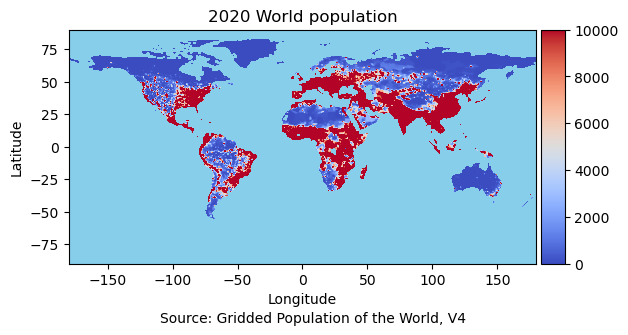

In [34]:
# TODO: WRITE YOUR CODES HERE

# This yields -inf, which doesn't really help us understand the data
print("The sum of all band cells is {}".format(band.sum()))

# Creating a copy of band so I can overwrite the data
test = band.copy()
test[test < 0] = 0
print("Once we set negative values to zero, the sum is {}".format(test.sum()))
# Once we set negative values to zero, we get just under 8 billion, so the units seem to be in individuals

# Plotting the data
fig, ax = plt.subplots()
cmap= plt.colormaps['coolwarm']
cmap.set_bad(color='skyblue')
# creating a masked array to color the ocean differently
masked_array = np.ma.masked_where(band < 0, band)
im = ax.imshow(masked_array, \
               cmap=cmap, \
               vmin=0, vmax=10000, \
               extent=[-180,180,-90,90]
              )

# Creating the colorbar and scaling to ax size
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

# Labeling
ax.set_title("2020 World population")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.text(-110,-135, 'Source: Gridded Population of the World, V4')
plt.show()

**3.2.**

This data set describes the total count of individuals in each grid cell, but we need a map of the _population density_, i.e. the number of individuals per square kilometer. 

**Make this map.**

To do this, you will need
* To figure out how large each grid cell is;
* To assume that 1 degree of latitude is 111.11 km and that 1 degree of longitude at the equator is 111.11 km;
* To use the `lat_grid` and `lon_grid` variables that we created above so that you can compute an array that is the same size as the original data set but where each element describes the area of the grid cell;
* To use map algebra to convert $population$ to $population/area$ to $\log_{10}(population/area)$, i.e. so a value of 1 indicates a density of 10 people per sq. km, 2 indicates a density of 100 people per sq. km, etc.

Draw your final map as  $\log_{10}(population/area)$, (otherwise it's too hard to see any of the structure in the data). Be sure it is visually clear and well labeled.

In [35]:
# TODO: WRITE YOUR CODES HERE

# we know each grid is centered 0.25 delta from the edge in lat and lon, therefore, the latitude width for each
# grid cell is 0.25*111.11km
width = 0.25*111.11

# longitude is calculated: 1 degree lon = 111.11cos(Latitutde) km
# writing function to convert longitude to kilometers
def longitude_to_km(longitude, latitude): 
    """
    Converts longitude to kilometers, given a particular latitude.
    Args:
        longitude: Degrees of longitude change (e.g. amount of longitude to convert to km)
        latitude: Latitude of object of interest
    Returns:
        Numpy.float: Distance in kilometers
    """
    # 1 degree lon = 111.11cos(Latitutde) km
    radians = (latitude * np.pi)/180 
    km = longitude * (111.11*np.cos(radians))
    return km

# converting longitude distances to kilometers
lon_grid_km = lon_grid.copy()
for i in range(len(lon_grid_km)):
    for j in range(len(lon_grid_km[0])):
        lon_grid_km[i][j] = longitude_to_km(0.25, lat_grid[i][j])

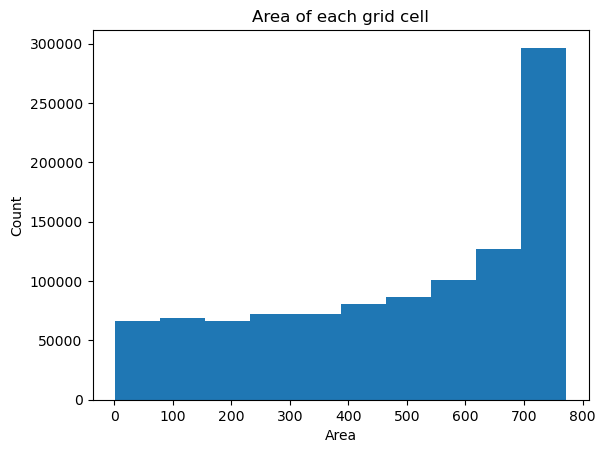

In [36]:
area = lon_grid_km * width
# plotting area to check calculation is done correctly
plt.hist(area.flatten())
plt.title("Area of each grid cell")
plt.xlabel("Area")
plt.ylabel("Count")
plt.show()

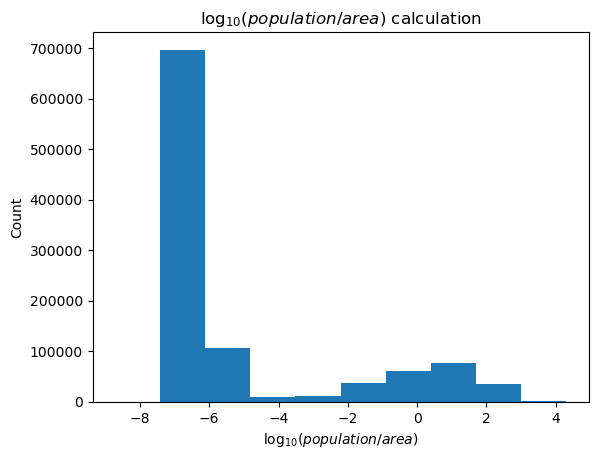

In [37]:
# Calculating population per square kilometer
pop = band.copy()
pop[pop<=0] = .0001
pop_area = pop / area

# Converting population/area to log base 10
# Plotting to make sure calculation is done correctly
log10_pop_area = np.log10(pop_area, where=(pop_area>0))
plt.hist(log10_pop_area.flatten())

plt.title("$\log_{10}(population/area)$ calculation")
plt.xlabel("$\log_{10}(population/area)$")
plt.ylabel("Count")
plt.show()

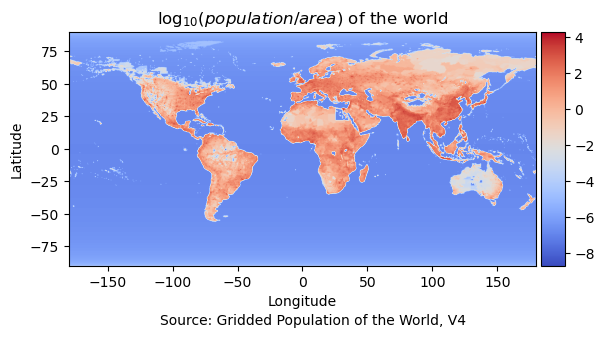

In [38]:
fig, ax = plt.subplots()

cmap= plt.colormaps['coolwarm']
# creating a masked array to color the ocean differently
# checking where the value is <-10 because some population density was so low, the values became negative
masked_array = np.ma.masked_where(log10_pop_area <-10 , log10_pop_area)

im = ax.imshow(masked_array, \
               cmap=cmap, \
               vmin=np.amin(log10_pop_area), vmax=np.amax(log10_pop_area), \
               extent=[-180,180,-90,90]
              )

# Creating the colorbar and scaling to ax size
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

# Labeling
ax.set_title("$\log_{10}(population/area)$ of the world")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.text(-110,-135, 'Source: Gridded Population of the World, V4')
plt.show()

**3.3.**

**Construct a global map where very densely populated locations are one color and less densely populated locations are another color.** Use the cutoff of 100 individuals per square kilometer.

In [39]:
density = band.copy()
density[density<=0] = -.0001
pop_density = density / area

# keeping this here for debugging purposes
# plt.hist(pop_density.flatten())

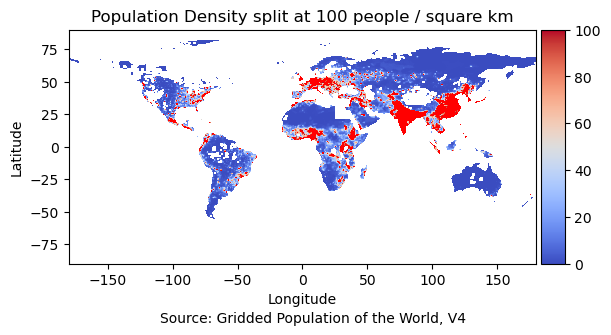

In [40]:
# TODO: WRITE YOUR CODES HERE

# Plotting the data
fig, ax = plt.subplots()
cmap1= plt.colormaps['coolwarm']
cmap1.set_over(color='red')
cmap1.set_under(color='blue')
cmap1.set_bad(color='white')
masked_array1 = np.ma.masked_where(pop_density < 0, pop_density)
im1 = ax.imshow(masked_array1, \
               cmap=cmap1, \
               vmin=0, vmax=100, \
               extent=[-180,180,-90,90], alpha=1
              )

# Creating the colorbar and scaling to ax size
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax)

# Labeling
ax.set_title("Population Density split at 100 people / square km")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.text(-110,-135, 'Source: Gridded Population of the World, V4')
plt.show()

**3.4.**

Load the shapefile of your chosen country that you mapped in Lab 4. If the country that you chose is hard to work with (e.g., if the geometries are too complicated, etc.), you can work with Mexico. You also may want to use the `simplify()` method in shapely in order to simplify your geometries to ease processing (otherwise this may run for a long time).

In a new figure, create a heat map of log10(population density) for the world. Then overlay on this map the boundary of your country (you can use `plt.plot()` and plot in the way that we've plotted shapely polygons or multipolygons). Use the `plt.set_xlim()` command to zoom into your country.

Hints:

1. In order to zoom in, you would probably need to find the bounds of a shapely object. `.bounds` can do that for you.
2. In `rasterio`, you can use `dataset.index()` to convert (x, y) coordinates to (i, j) coordinates. This will be useful when you, for example, know the lon, lat coordinates of all the points on a shapely polygon and want to convert them to (i, j) coordinates. Call the function this way
```python
row, col = dataset.index(x, y)
```
In `rasterio`, you would have no. of rows = height and no. of cols = width. This also means that `dataset.shape = (dataset.height, dataset.width)` which is not always the convention for some other packages.
3. Always check if anything has been plotted sideways or doesn't match up. Always check your axis labels too. You can never be too careful in terms of alignment of data from multiple sources.

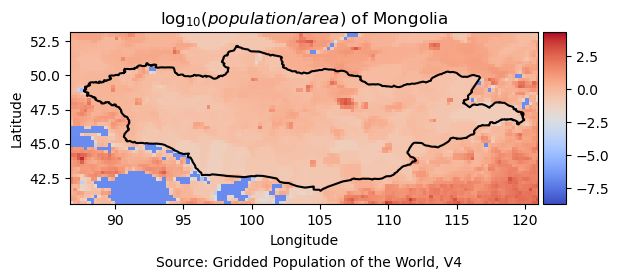

In [41]:
# TODO: WRITE YOUR CODES HERE

fig, ax = plt.subplots()

cmap= plt.colormaps['coolwarm']
# creating a masked array to color the ocean differently
# checking where the value is <-10 because some population density was so low, the values became negative
masked_array = np.ma.masked_where(log10_pop_area <-10 , log10_pop_area)

im = ax.imshow(masked_array, \
               cmap=cmap, \
               vmin=np.amin(log10_pop_area), vmax=np.amax(log10_pop_area), \
               extent=[-180,180,-90,90]
              )

# Creating the colorbar and scaling to ax size
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

# Labeling
ax.set_title("$\log_{10}(population/area)$ of Mongolia")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.text(93,36, 'Source: Gridded Population of the World, V4')


# Plotting Mongolia here
df = gpd.read_file('/Users/jaredschober/Documents/GSPP/Fall_2022/pp275/Labs/Lab4/MNG_adm/MNG_adm0.shp')
x,y = df['geometry'].exterior[0].xy
min_x = df['geometry'].bounds.minx
ax.set_xlim(df['geometry'].bounds['minx'][0]-1,df['geometry'].bounds['maxx'][0]+1)
ax.set_ylim(df['geometry'].bounds['miny'][0]-1,df['geometry'].bounds['maxy'][0]+1)
ax.plot(x,y, color=(0/255 ,0/255 ,0/255))
plt.show()

**3.5.**

The map with the boundary of your country overlaid is nice, but sometimes we want to clip out the information around the country of interest. To do this, we need to create a mask that we can use to "erase" all the population data that is outside of our country. Do this with the `rasterio.mask.mask()` function on **the original GPW raster**. This function takes the vector shapefile of a country and extracts pixels within the shapefile polygons. The function doesn't just output an array of ones and zeros. Instead, it assigns a value specified by the user with the `nodata` argument (this defaults to 0) to cells outside of the country, and retains the cells within the country. **Now show the clipped raster. Turn in this figure.**

Hints:

1. To use the mask function, you can do, for example,
```python
rasterio.mask.mask(dataset, shp, nodata=-1)
```
Assuming that shp is a shapely polygon or multipolygon.
2. The returned array will have one additional dimension, you can use the `.squeeze()` method on numpy arrays to reduce the unnecessary dimension. This is usually reserved for rasters with multiple bands but here we only have one.

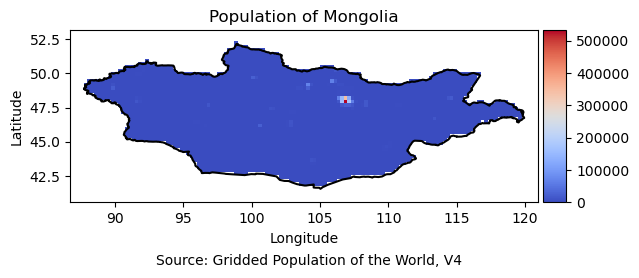

In [42]:
# TODO: WRITE YOUR CODES HERE
mask = rasterio.mask.mask(dataset, df['geometry'], nodata=-1)
mask = mask[0].squeeze()
np.amax(mask)

fig, ax = plt.subplots()

cmap= plt.colormaps['coolwarm']
cmap.set_under(color='white')
im = ax.imshow(mask, \
               cmap=cmap, \
               vmin=0, vmax=np.amax(mask), \
               extent=[-180,180,-90,90]
              )

# Creating the colorbar and scaling to ax size
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

# Labeling
ax.set_title("Population of Mongolia")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.text(93,36, 'Source: Gridded Population of the World, V4')

x,y = df['geometry'].exterior[0].xy
min_x = df['geometry'].bounds.minx
ax.set_xlim(df['geometry'].bounds['minx'][0]-1,df['geometry'].bounds['maxx'][0]+1)
ax.set_ylim(df['geometry'].bounds['miny'][0]-1,df['geometry'].bounds['maxy'][0]+1)
ax.plot(x,y, color=(0/255 ,0/255 ,0/255))
plt.show()

**3.6.**

Plot a global map of log10(population density), but now use a different projection of the globe. A list of projections is provided [here](https://www.spatialreference.org/ref/epsg/).

**Turn in one figure that is not a standard Mercator projection. Make your plot clear and appealing.**

This is a very challenging question, so if you want to follow the steps below and turn in a plot in the Pseudo Mercator system, that is totally fine!

Suppose that we want to reproject this raster onto the Pseudo Mercator system - this is super useful as many web apps use this system (e.g., Google Maps). The ID for this coordinate reference system is 3857.

In [43]:
# declares the destination coord system
dst_crs = 'EPSG:3857'

The Pseudo Mercator system only covers 85.06 S to 85.06 N. So we would want to 'subset' our raster `dataset`. Unlike in pandas, etc., this isn't going to be very straightforward.

In [44]:
# since web mercator only covers latitude of -85.06 to 85.06
# calculate the height of the subsetted array first
height = int(dataset.height * 85 / 90)
# subset the source array (read values within 85S to 85N only)
src_array = dataset.read(1, window=rasterio.windows.Window(
    col_off=0, row_off=int((dataset.height - height) / 2),
    width=dataset.width, height=height))
# calculate a new `transform` for the original raster
# this is an object that keeps track of geocoding information
# for the original raster
src_transform = rasterio.transform.Affine(
    dataset.transform.a, dataset.transform.b,
    dataset.transform.c, dataset.transform.d,
    dataset.transform.e, 85)

Until now we have been 'subsetting' our original raster and extract the part that's in 85S-85N. Apart from subsetting our numpy array, we would also want to update some geo metadata information, which is what we did with `src_transform`. Now let's compute the metadata of the new destination raster.

In [45]:
# this calculates the transform to be applied onto
# the original raster
dst_transform, dst_width, dst_height = rasterio.warp.calculate_default_transform(
    # the coordinate reference system for source raster
    src_crs=dataset.crs,
    # the coordinate reference system for destination raster
    dst_crs=dst_crs,
    # width and height for source raster
    width=dataset.width,
    height=dataset.height,
    # bounds for source raster
    left=-180,
    right=180,
    top=85,
    bottom=-85,
)

Now we want to reproject the original raster and create a new raster to store the reprojected output - let's call that `dst_array`.

In [46]:
# creates a zero array to store the reprojected raster
dst_array = np.zeros((dst_height, dst_width))
# reproject the raster array
rasterio.warp.reproject(
    source=src_array,
    destination=dst_array,
    src_transform=src_transform,
    src_crs=dataset.crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=rasterio.warp.Resampling.nearest)

(array([[-3.40282306e+38, -3.40282306e+38, -3.40282306e+38, ...,
         -3.40282306e+38, -3.40282306e+38, -3.40282306e+38],
        [-3.40282306e+38, -3.40282306e+38, -3.40282306e+38, ...,
         -3.40282306e+38, -3.40282306e+38, -3.40282306e+38],
        [-3.40282306e+38, -3.40282306e+38, -3.40282306e+38, ...,
         -3.40282306e+38, -3.40282306e+38, -3.40282306e+38],
        ...,
        [-3.40282306e+38, -3.40282306e+38, -3.40282306e+38, ...,
         -3.40282306e+38, -3.40282306e+38, -3.40282306e+38],
        [-3.40282306e+38, -3.40282306e+38, -3.40282306e+38, ...,
         -3.40282306e+38, -3.40282306e+38, -3.40282306e+38],
        [-3.40282306e+38, -3.40282306e+38, -3.40282306e+38, ...,
         -3.40282306e+38, -3.40282306e+38, -3.40282306e+38]]),
 Affine(35144.70279447101, 0.0, -20037508.342789244,
        0.0, -35144.70279447101, 19971868.88040857))

You'll notice that the reprojected map is a square. This is a very interesting and useful property of the Pseudo Mercator system and is part of the reason why it is popular, especially in web based mapping programs.

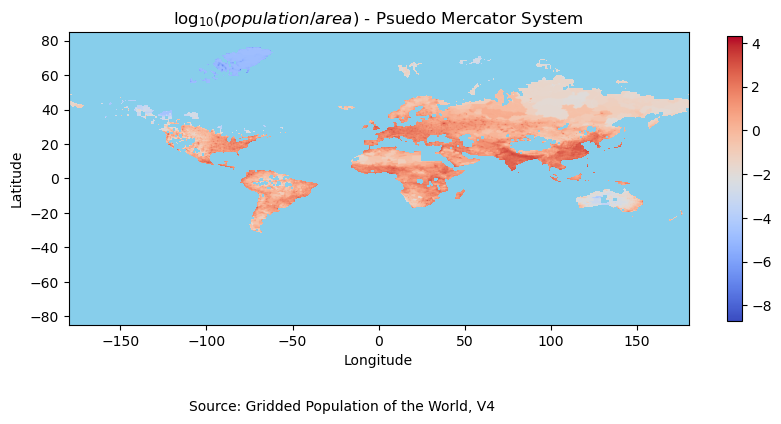

In [47]:
# TODO: WRITE YOUR CODES HERE
# YOU CAN USE THE CODES/OBJECTS ABOVE IF YOU WANT TO
# TRY TO UNDERSTAND THE STEPS IN THE ABOVE CODES

dst_array[dst_array<=0]=-0.0001 # setting an obvious bad value
delta_width = (360/dst_width)
lons_1 = np.arange(start=-179.5, stop=180 + delta_width, step=delta_width)
delta_height = (180/dst_height)
lats_1 = np.arange(start=89.75, stop=-90 - delta_height, step=-delta_height)

lon_grid_1, lat_grid_1 = np.meshgrid(lons_1, lats_1)

lon_grid_km_1 = 111.11 * np.cos(lat_grid_1 / 180 * np.pi) # doing this instead of my above function b/c it's cleaner
grid_size_1 = (delta_width * lon_grid_km_1) * (delta_height * 111.11)
pop_area_1 = dst_array/grid_size_1
pop_area_1[pop_area_1<0]=-1000
log10_pop_area_1 = np.log10(pop_area_1, where=(pop_area_1>0))
masked_array_pseudo = np.ma.masked_where(pop_area_1 < 0 , log10_pop_area_1)
fig, ax = plt.subplots(figsize=(10,10))
cmap= plt.colormaps['coolwarm']
cmap.set_bad(color='skyblue')
im = ax.imshow(masked_array_pseudo, \
               cmap=cmap, \
               vmin=np.amin(masked_array_pseudo), vmax=np.amax(masked_array_pseudo), \
               extent=[-180,180,-85,85]
              )
ax.set_title("$\log_{10}(population/area)$ - Psuedo Mercator System")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.text(-110,-135, 'Source: Gridded Population of the World, V4')
fig.colorbar(im, ax=ax, shrink=0.37)
plt.show()

## Congratulations!
You've finished this lab! Things will only get easier from here, and more enjoyable.

* **Please list everyone you worked on this assignment with outside of Ed Discussion.**
* Dominic Fusco
* Bailey Schweitzer
* Eliza Pugh

When you are done with the lab, please restart the kernel and run all the codes one more time (press the ">>" button), so that the grader will see a clean notebook. Don't forget to save! Please submit this lab to bCourses as `YOURCAL1ID.ipynb`.